# Exercise 11: Autoencoder Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
# Use built-in Pytorch function to download MNIST data in usable format 
# the images are automatically normalised to a mean of zero and sigma of 1 

batch_size = 100

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) # initial mean and width
                             ])),
  batch_size=batch_size, shuffle=True)


torch.Size([100, 1, 28, 28])


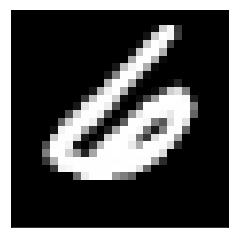

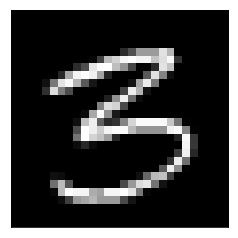

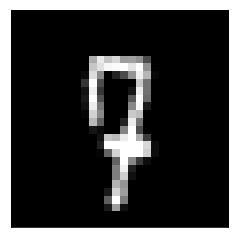

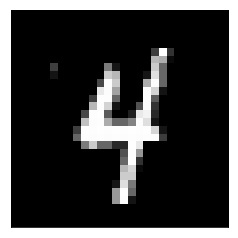

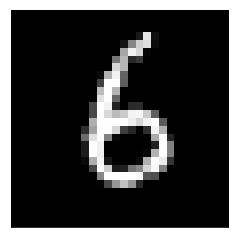

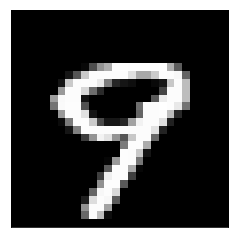

In [3]:
# Helper function to draw MNIST image
# expect a 2D tensor as input
def draw_image(im):
    plt.imshow(im, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.show()


examples = enumerate(train_loader)
for batch_idx, (example_data, example_targets) in examples:

    # First print the shape of the example_data tensor
    print(example_data.shape) # 100 examples, 1 color, 28x28 pixel images
    
    # Show the first 6 images
    for i in range(6):
        draw_image(example_data[i][0])
        

    break # Abort the loop over the input data

In [4]:
# A few useful functions

# Produce random numbers as input for generator
# torch.randn produces random numbers following 
# a Gaussian with mean=0 and sigma=1
def noise(size):
    return torch.autograd.Variable(torch.randn(size, 100))

# Translate images to flat vectors (784 = 28*28)
def images_to_vectors(images):
    return images.view(images.size(0), 784)

# Translate flat vectors to images in the format (color, vertical, horizontal)
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [5]:
# The code below implements a (technically) fully functional variational autoencoder
# However it will need to be a bit more complex to give good performance

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Layers for the encoder
        self.fc1 = nn.Linear(784, 20)
        self.fc2 = nn.Linear(784, 20)
        
        # Layers for the decoder
        self.fc3 = nn.Linear(20,784)

        
    def encode(self,x):
        # Encoder part of the network
        # We have one layer to calculate mu and one to calculate sigma
        # Ideally we would have a few shared layers for mu and sigma 
        # and the final layers separate. Of course the intermediate
        # layers should also include activiation functions
        mu    =  self.fc1(x)
        sigma =  self.fc2(x)
            
        return mu,sigma
    
    def decode(self, z):
        # Decoder part of the network
        # This could also be more complex. Make sure to keep the sigmid
        # as final actication
        return F.sigmoid(self.fc3(z))
        
    def sample(self, mu, sigma):

        # randn_like produces random numbers using a Gauss(0,1) distribution
        # as a tensor with the same shape as its argument
        eps = torch.randn_like(sigma)
        z = mu + eps*sigma
        
        return z
    
        
    def forward(self, x):
        
        # this is the forward pass
        
        # run the encoder
        mu,sigma = self.encode(x)
        
        # sample from Gauss(mu,sigma)
        z = self.sample(mu,sigma)
                
        # and put it into the decoder
        out = self.decode(z)

        return out, mu, sigma

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')          
model = VAE().to(device)

# We need two optimisers, one for the generator, one for the discriminator network
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Reconstruction loss function
def loss_function(recon_x, x, mu, sigma):

    # Binary cross entropy
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # Here we are missing the Kullback-Leiber divergence
    # You should calculate it following the formula derived in the lecture
    # For a tensor T you can call T.pow(2) to square it
    # and T.log() to calculate the logarithm
    # torch.sum(T) sums over the different axes of a tensor and return a scalar
    KLD = 0
    
    
    return BCE + KLD

Epoch: 0, Batch: 0, Loss: 56618.83203125


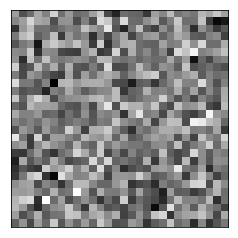

Epoch: 0, Batch: 500, Loss: -526814025.6027832


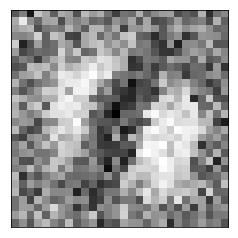

Epoch: 1, Batch: 0, Loss: -1468174.25


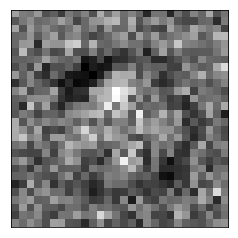

Epoch: 1, Batch: 500, Loss: -746432739.375


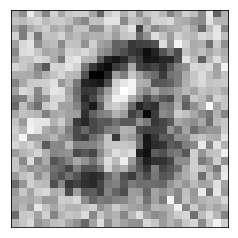

Epoch: 2, Batch: 0, Loss: -1530067.375


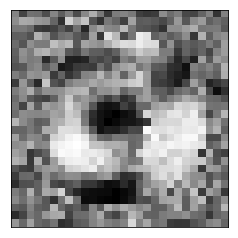

Epoch: 2, Batch: 500, Loss: -764647302.125


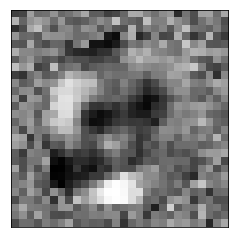

Epoch: 3, Batch: 0, Loss: -1520712.25


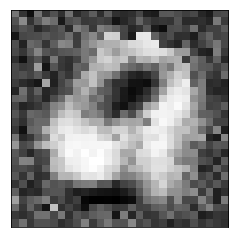

Epoch: 3, Batch: 500, Loss: -757261826.875


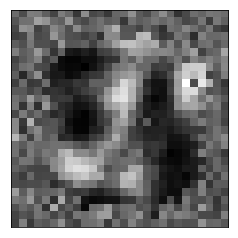

Epoch: 4, Batch: 0, Loss: -1468817.5


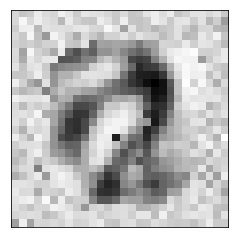

Epoch: 4, Batch: 500, Loss: -741664109.25


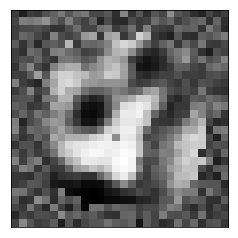

Epoch: 5, Batch: 0, Loss: -1447511.125


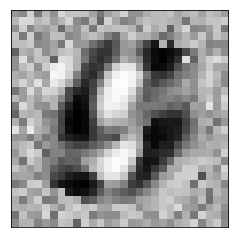

Epoch: 5, Batch: 500, Loss: -725033929.125


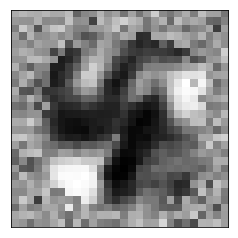

Epoch: 6, Batch: 0, Loss: -1451153.25


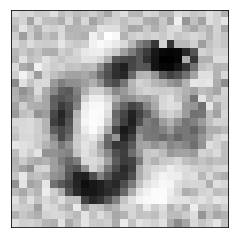

Epoch: 6, Batch: 500, Loss: -710987843.875


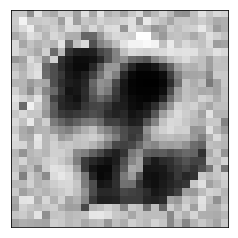

Epoch: 7, Batch: 0, Loss: -1415893.5


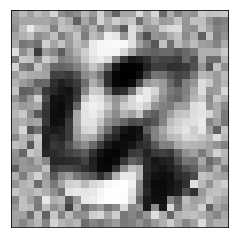

Epoch: 7, Batch: 500, Loss: -699516214.25


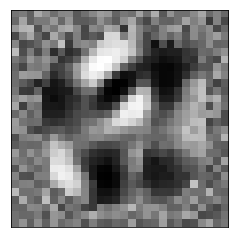

Epoch: 8, Batch: 0, Loss: -1352049.375


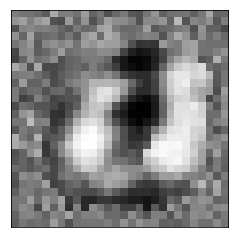

Epoch: 8, Batch: 500, Loss: -692027172.75


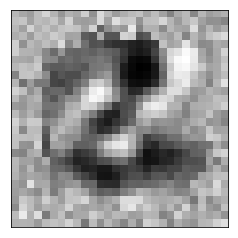

Epoch: 9, Batch: 0, Loss: -1405118.75


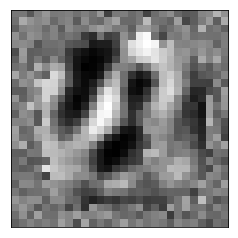

Epoch: 9, Batch: 500, Loss: -684016699.125


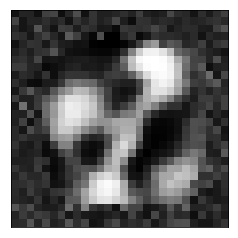

In [8]:
# The code below handles the training of the GAN

# Total number of epochs to train
n_epochs = 10

# Loop over epochs
for epoch in range(n_epochs):
    
    # Loop over training examples
    examples = enumerate(train_loader)
    
    train_loss = 0
    
    for i_batch, (data, _) in examples:

        # Prepare input data
        data = torch.autograd.Variable(images_to_vectors(data))

        # reset readients
        optimizer.zero_grad()
                
        # apply model to data and get the decoder output as well as the
        # latent space variables
        recon_batch, mu, sigma = model(data)
        
        # calculate the loss function and update gradients
        loss = loss_function(recon_batch, data, mu, sigma)
        loss.backward() 
        optimizer.step()
        
        train_loss += loss.item()
        
        # Show status every few batches
        if (i_batch) % 500 == 0: 
        
            # throw random numbers and let the autoencoder build images
            sample = torch.randn(20).to(device)
            sample = model.decode(sample).cpu()
    
            print("Epoch: {0}, Batch: {1}, Loss: {2}".format(epoch,i_batch,train_loss))
            draw_image(sample.view(1, 28, 28).detach().numpy()[0])

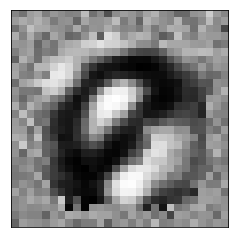

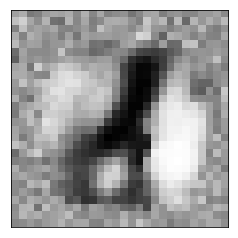

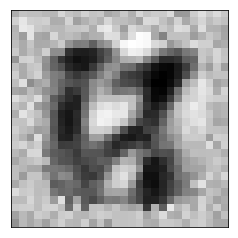

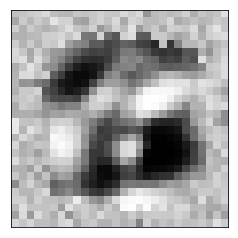

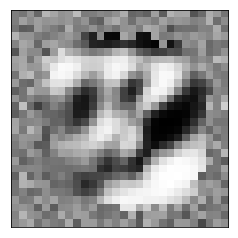

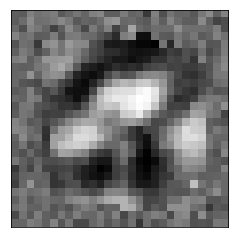

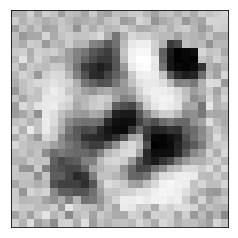

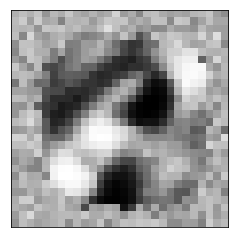

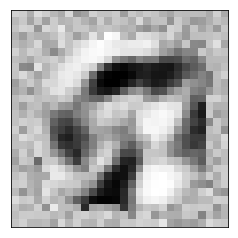

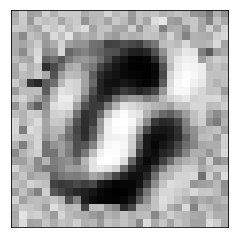

In [9]:
# Produce 10 examples
sample = torch.randn(10,20).to(device)
sample = model.decode(sample).cpu()
for i in range(10):
    draw_image(sample.view(-1,1, 28, 28)[i].detach().numpy()[0])

# Homework


The code above should be fully functional but not do a very good job. 

  *  The loss function is missing the KL-Divergence term that ensures the latent space distribution to be Gaussian with the correct parameters. 
  * The network architecture is seriously underpowered.
  
 Fix these two issues and train a working MNIST VAE. Some more details are in the code above.


